# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os


2024-03-06 00:51:31.152936: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 00:51:31.182657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 00:51:31.182680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 00:51:31.183592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 00:51:31.188441: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

/home/big/Kevin/Workspace/Homework/ecec147/project/Deep-Learning-EEG-BCI-Signal-Processing/EEG-Data


(2115, 22, 1000)


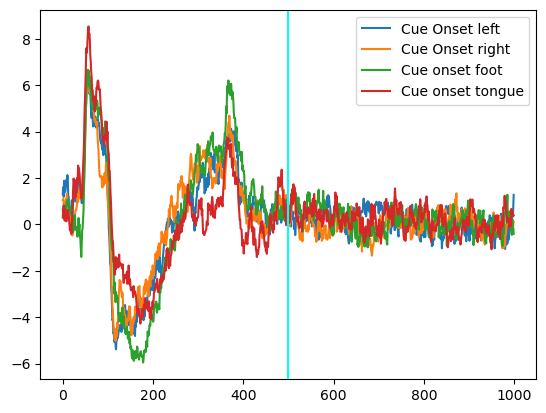

In [3]:
## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






# Data Preprocessing

In [4]:

## Preprocessing the dataset

X_train_valid_prep = X_train_valid[:,:,0:500]
X_test_prep = X_test[:,:,0:500]

print("X train val prep", X_train_valid_prep.shape)
print("y train val prep", y_train_valid.shape)
print("X test prep", X_test_prep.shape)
print("y test", y_test.shape)


## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

#print("old y_train", y_train[:10])

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

#print("new y_train", y_train[:10])

print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

print("X val", x_valid.shape)
print("y val", y_valid.shape)

print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

X train val prep (2115, 22, 500)
y train val prep (2115,)
X test prep (443, 22, 500)
y test (443,)
Shape of training set: (1615, 22, 500)
Shape of validation set: (500, 22, 500)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 500, 1)
Shape of validation set after adding width info: (500, 22, 500, 1)
Shape of test set after adding width info: (443, 22, 500, 1)
X val (500, 500, 1, 22)
y val (500, 4)
Shape of training set after dimension reshaping: (1615, 500, 1, 22)
Shape of validation set after dimension reshaping: (500, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)


# CNN Model Architecture

In [34]:
from EEG_CNN import CNN

In [67]:
import itertools
# Building the CNN model using sequential class
mp = {'max pool' : True}
reg = {'reg 1e-3': 1e-3}
convdrop = {'conv drop': True}
filters = {'5x1 filter': 5}
convdepth = {'10 convlayers': 10}

models_names = []
models = []
for a in itertools.product(mp.items(), reg.items(), convdrop.items(), filters.items(), convdepth.items()):
    models_names.append([i[0] for i in a])
    models.append(CNN(use_max_pool=a[0][1], reg=a[1][1], dropout_on_conv=a[2][1], 
                      filters=[a[3][1] for _ in range(a[4][1])],
                      num_filters=[min(200, 25 * (2 ** i)) for i in range(a[4][1])]))

# Printing the model summary
# basic_cnn_model.summary()


# Train CNN Model

In [68]:
# Model parameter
# learning_rate = keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps)
learning_rate = 3e-3

epochs = 1000
# cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [69]:
# Compiling the model
from keras.callbacks import ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
for model in models:
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
histories = []
for model in models:
# Training and validating the model
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8,
                              patience=20, min_lr=5e-5)
    histories.append(model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[reduce_lr],
             verbose=True)
    )



Epoch 1/1000


2024-03-06 10:47:56.221661: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_80/dropout_306/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


26/26 [==============================] - 4s 25ms/step - loss: 3.5200 - accuracy: 0.2619 - val_loss: 4.5329 - val_accuracy: 0.2500 - lr: 0.0030
Epoch 2/1000
26/26 [==============================] - 1s 20ms/step - loss: 3.1389 - accuracy: 0.2570 - val_loss: 9.7373 - val_accuracy: 0.2500 - lr: 0.0030
Epoch 3/1000
26/26 [==============================] - 0s 16ms/step - loss: 2.9931 - accuracy: 0.2824 - val_loss: 4.3837 - val_accuracy: 0.2700 - lr: 0.0030
Epoch 4/1000
26/26 [==============================] - 0s 19ms/step - loss: 2.8773 - accuracy: 0.2793 - val_loss: 3.1974 - val_accuracy: 0.2300 - lr: 0.0030
Epoch 5/1000
26/26 [==============================] - 0s 19ms/step - loss: 2.8416 - accuracy: 0.2830 - val_loss: 2.8570 - val_accuracy: 0.2900 - lr: 0.0030
Epoch 6/1000
26/26 [==============================] - 1s 20ms/step - loss: 2.7738 - accuracy: 0.2619 - val_loss: 2.7151 - val_accuracy: 0.2720 - lr: 0.0030
Epoch 7/1000
26/26 [==============================] - 0s 19ms/step - loss: 2.

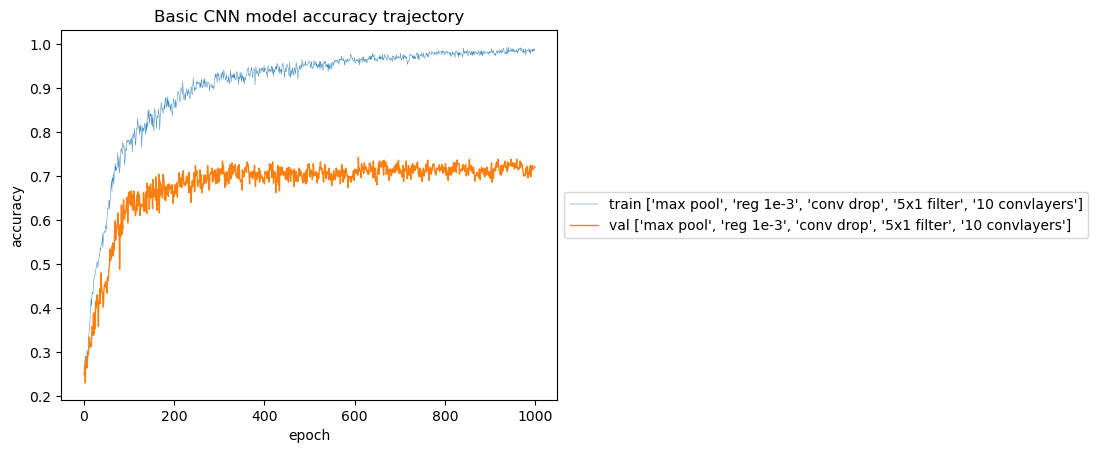

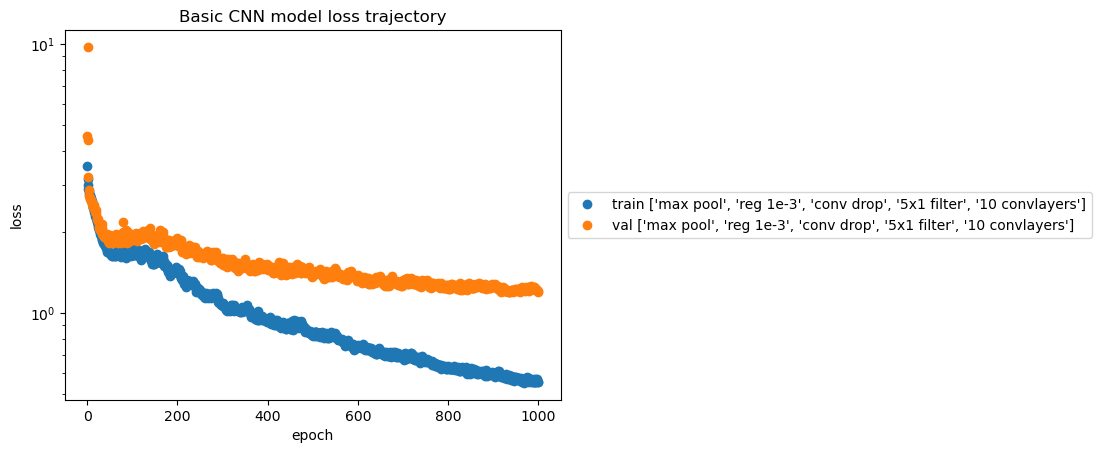

In [70]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
for hist in histories:
    plt.plot(hist.history['accuracy'], linewidth=0.3)
    plt.plot(hist.history['val_accuracy'], linewidth=1)
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
labels = []
for name in models_names:
    labels.append(f'train {name}')
    labels.append(f'val {name}')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
for hist in histories:
    plt.plot(hist.history['loss'],'o')
    plt.plot(hist.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [71]:
## Testing the basic CNN model

for model, name in zip(models, models_names):
    cnn_score = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test accuracy of {name}:',cnn_score[1])

Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '10 convlayers']: 0.7088035941123962


In [72]:
maxes_ = []
finals_ = []
for model, name in zip(histories, models_names):
    maxes_.append(max(model.history['val_accuracy']))
    finals_.append(model.history['val_accuracy'][-1])
    print(f"Validation accuracy {name}: max: {max(model.history['val_accuracy'])}, final: {model.history['val_accuracy'][-1]}")
for pair in sorted(zip(finals_, models_names), key=lambda i: i[0], reverse=True):
    print(pair)

Validation accuracy ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '10 convlayers']: max: 0.7419999837875366, final: 0.7200000286102295
(0.7200000286102295, ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '10 convlayers'])


In [73]:
color = ['r', 'b', 'g']
for param in [mp.items(), reg.items(), convdrop.items(), filters.items(), convdepth.items()]:
    if len(param) == 1:
        continue
    for i, param_name in enumerate(param):
        for name, label, history in zip(models_names, labels[1::2], histories):
            if param_name[0] in name:
                plt.plot(history.history['val_accuracy'], linewidth=1, color=color[i], label=label)
    plt.title('Basic CNN model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()